In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from functools import reduce
from typing import Union, List

%matplotlib inline

# Data preparation

In [2]:
data = pd.read_csv('/home/edward/notebooks/data/Titanic_data/train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data = pd.concat([data, pd.get_dummies(data.loc[:, 'Pclass'])], axis=1)
data.drop(['PassengerId', 'Pclass', 'Name', 'Parch', 'SibSp', 'Ticket', 'Fare', 'Cabin', 'Embarked'], 
          axis=1, 
          inplace=True)
data.dropna(inplace=True)
data.interpolate(inplace=True)

In [5]:
X, y = dc(data.values[:, 1:]), dc(data.values[:, 0])

In [6]:
# encode 'male' and 'female' as 1 and 0
_, encoded = np.unique(X[:, 0], return_inverse=True)
X[:, 0] = encoded

# add additianal axis. (714,) -> (714, 1)
y = y[:, np.newaxis]

In [7]:
# output first 10 of current sets
for i, (x_, y_) in enumerate(zip(X, y)):
    if i == 10:
        break
    print('{:<3} X: {} y: {}'.format(i+1, x_, y_))

1   X: [1 22.0 0 0 1] y: [0]
2   X: [0 38.0 1 0 0] y: [1]
3   X: [0 26.0 0 0 1] y: [1]
4   X: [0 35.0 1 0 0] y: [1]
5   X: [1 35.0 0 0 1] y: [0]
6   X: [1 54.0 1 0 0] y: [0]
7   X: [1 2.0 0 0 1] y: [0]
8   X: [0 27.0 0 0 1] y: [1]
9   X: [0 14.0 0 1 0] y: [1]
10  X: [0 4.0 0 0 1] y: [1]


In [8]:
X.shape, y.shape

((714, 5), (714, 1))

# Neural Net

In [9]:
class NeuralNetwork:
    def __init__(self, rate=0.01,
                       epochs=500,
                       hidden_layers=[4, 6, 4],
                       output_layer=None,
                       regularization=0,
                       poly_power=2):
        """
        Base constructor for neural network.

        Parameters
        ----------
        rate : float (default 0.01)
            The learning rate.

        epochs : int (default 500)
            Quantity of iterations.

        hidden_layers : list (default [4, 6, 4])
            Neurons each of hidden layer.
            4 neurons for first hidden layer, 6 - for second, etc...

        output_layer : int (default None)
            Quantity of output layer neurons.

            Note: it must be initialized.

        regularization : float (default 0)
            Used to balance between underfitting and overfitting.

            Note: the bigger value, the less model fits to the data (causes underfitting)
                the smaller value, the more model fits to the data (causes overfitting)

        poly_power : int (default 2)
            Max power of polynomial features.

        Variables
        ---------
        inputLS : int
            Quantity of input layer neurons.

            Note: input layer size is being initialized during fit function
                in regard to Xtrain shape

        weights : list
            List of weights.

            Note: Weights are kept in the list, where each element of the list
                is weights between certain layers

        J : list
            History of loss function

        J_valid : list
            History of validation loss function

        _z : list
            Layers multiplied by weights are kept here.

        _a : list
            Applied sigmoid function on layers, that are in _z

        _dJdW : list
            Derivatives of cost function

        """

        self.rate = rate
        self.epochs = epochs
        self.inputLS = None
        self.hiddenLS = hidden_layers
        self.outputLS = output_layer
        self.weights = []
        self.regularization = regularization
        self.poly = poly_power

        self.J = []
        self.J_valid = []
        self._z = []
        self._a = []
        self._dJdW = []

    def tanh(self, z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        return np.tanh(z)

    def relu(self, z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        return np.maximum(np.zeros(z.shape[0]), z)

    def sigmoid(self, z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        return 1 / (1 + np.e**(-z))

    def sigmoid_derivative(self, z):
        # Derivative of vanilla sigmoid function
        return np.e**(-z) / (1 + np.e**(-z))**2

    def normalization(self, X: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        # normalize data
        return (X - X.mean(axis=0)) / (X.max(axis=0) - X.min(axis=0))

    def cost(self, X, y):
        """
        Compute loss using the cost function.

        Parameters
        ----------
        X : numpy.ndarray, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : numpy.ndarray, shape (n_samples, 1) or (n_samples, n_labels)
            Target relative to X for classification or regression;
            None for unsupervised learning.

        Returns
        -------
        numpy.ndarray
            Shape of array (n_samples, 1) or (n_samples, n_labels)

            Note: In case of multiclass,
                this function returns in onehot encoded format.

        Examples
        --------
        >>> X = np.array([[1, 2, 3],
                          [4, 5, 6]])
        >>> y = np.array([[1, 0, 0],
                          [0, 1, 0]])
        >>> cost(X, y)
        [[0.87, 0.23, 0.54],
         [0.42, 0.98, 0.13]]

        """
        
        # feedforward pass
        h = self.feedforward(X)
        
        # add regularization
        # square each of weights (theta)
        sqr_weights = list(map(lambda x: np.sum(x ** 2), self.weights))
        # sum up weights
        sum_weights = reduce(lambda x, y: x+y, sqr_weights)
        
        return 0.5 * sum((y - h)**2) / X.shape[0] + \
            self.regularization / (2*X.shape[0]) * sum_weights
        
    def cost_derivative(self, X, y):
        """
        Compute loss using derivative of cost function.

        Parameters
        ----------
        X : numpy.ndarray, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : numpy.ndarray, shape (n_samples, 1) or (n_samples, n_labels)
            Target relative to X for classification or regression;
            None for unsupervised learning.

        Returns
        -------
        numpy.ndarray
            Shape of array (n_samples, 1) or (n_samples, n_labels)

            Note: In case of multiclasses,
                this function returns in onehot encoded format.

        """

        # clear all saved layers
        del self._dJdW[:]
        del self._a[:]
        del self._z[:]

        # calculate derivative of cost function
        h = self.feedforward(X)

        # last (output) layer
        delta = -(y - h) * self.sigmoid_derivative(self._z[-1])

        # add regularization
        derivated = np.dot(self._a[-2].T, delta) + self.regularization * self.weights[-1]
        self._dJdW.append(derivated)

        # go back through all hidden layers
        for i in reversed(range(1, len(self._a) - 1)):
            delta = np.dot(delta, self.weights[i+1].T) * self.sigmoid_derivative(self._z[i])
            # add regularization
            derivated = np.dot(self._a[i - 1].T, delta) + self.regularization * self.weights[i]
            self._dJdW.append(derivated)

        # first (input) layer
        delta = np.dot(delta, self.weights[1].T)

        # add regularization
        derivated = np.dot(X.T, delta) + self.regularization * self.weights[0]
        self._dJdW.append(derivated)

        # reverse list of derivations
        self._dJdW = self._dJdW[::-1]

        return self._dJdW

    def feedforward(self, X):
        """
        Compute feedforward pass through the neural network to derive a hypothesis.

        Parameters
        ----------
        X : numpy.ndarray, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        -------
        numpy.ndarray, shape (n_samples, 1) or (n_samples, n_features)

            Note: In case of multiclasses,
                this function returns in onehot encoded format.

        """

        h = X
        for current_weight in self.weights:
            z = np.dot(h, current_weight)
            a = self.sigmoid(z)

            self._z.append(z)
            self._a.append(a)

            h = a

        return h

    def encode_onehot(self, y):
        """
        Encode training set of labels into onehot format.

        Parameters
        ----------
        y : numpy.ndarray, shape (n_samples, 1)
            The training set of labels.

        Returns
        -------
        numpy.ndarray
            Shape (n_samples, n_labels).

        Examples
        --------
        >>> y = np.array([[0],
                          [2],
                          [4],
                          [1],
                          [2]])
        [[1, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 1],
         [0, 1, 0, 0, 0],
         [0, 0, 1, 0, 0]]

        """

        names, encoded = np.unique(y, return_inverse=True)
        m = np.full((encoded.shape[0], names.shape[0]), 10e-5)
        m[np.arange(encoded.shape[0]), encoded] = 1

        return m

    def _shuffle(self, X, y):
        """
        Shuffle given sets.

        Parameters
        ----------
        X : numpy.ndarray, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : numpy.ndarray, shape (n_samples, 1) or (n_samples, n_features)
            Target relative to X for classification or regression.
            None for unsupervised learning.

        Returns
        -------
        tuple(numpy.ndarray, numpy.ndarray)
            Shuffled given sets.
            Correspondence of features and labels is preserved.

        """

        # build an array with the same dimension
        indexes = np.arange(X.shape[0])

        # shuffle indexes
        np.random.shuffle(indexes)

        # assign
        X, y = X[indexes], y[indexes]

        return X, y

    def split_data(self, X, y, ratio):
        """
        Split given sets in regard to ratio.

        Parameters
        ----------
        X : numpy.ndarray, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

        y : numpy.ndarray, shape (n_samples, 1) or (n_samples, n_labels)
            Target relative to X for classification or regression.
            None for unsupervised learning.

        ratio : float
            Value in range (0, 1).

        Returns
        -------
        tuple(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

        Examples
        --------
        >>> X.shape, y.shape
        ((100, 4), (100, 1))
        >>> split_data(X, y, ratio=0.2)
        ((80, 4), (80, 1), (20, 4), (20, 1))

        """

        X, y = self._shuffle(X, y)

        size1 = int(X.shape[0] * ratio)
        size2 = int(X.shape[0] - size1)

        return X[:size2], y[:size2], X[-size1:], y[-size1:]

    def _add_poly_features(self, X):
        """
        Add polynomial features.

        Parameters
        ----------
        X : numpy.ndarray, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and
            n_features is the number of features.

            Note: polynomial power is initialized during defining model.
                  There is no need to call this function.
                  In case of initializing the polynomial power,
                    it runs automatically.

        Returns
        -------
        numpy.ndarray
            Shape (n_samples, n_labels).

        Examples
        --------
        >>> X = np.array([[2, 3],
                          [4, 5],
                          [3, 2],
                          [....]])
        >>> model = NeuralNetwork(poly_power=3)
        >>> model._add_poly_features(X)
        [[2, 3, 4, 9, 8, 27],
         [4, 5, 16, 25, 64, 125],
         [3, 2, 9, 4, 27, 8]]

        """

        base_num_features = X.shape[1]
        for power in range(2, self.poly+1):
            new_feature = X[:, :base_num_features] ** power
            X = np.concatenate([X, new_feature], axis=1)

        return X

    def _randomize_weights(self):
        """
        Randomize initial weights of neural network
        in regard to shape of Xtrain, ytrain and hidden layers.

        """

        # randomize input weights
        self.W = np.random.randn(self.inputLS, self.hiddenLS[0])
        self.weights.append(self.W)

        # randomize weights between all hidden layers
        for i in range(len(self.hiddenLS)-1):
            self.W = np.random.randn(self.hiddenLS[i], self.hiddenLS[i+1])
            self.weights.append(self.W)

        # randomize output weights
        self.W = np.random.randn(self.hiddenLS[-1], self.outputLS)
        self.weights.append(self.W)

    def fit(self, X, y, normalize=False, validation_split=None):
        """
        Preprocess data, generate weights and train model.

        Parameters
        ----------
        X : numpy.ndarray, shape (n_samples, n_features)
            The training set of features.

        y : numpy.ndarray, shape (n_samples, 1) or (n_samples, n_labels)
            The training set of labels.

        normilize : bool (default False)
            Data normalization.

        validation_split : float (default None)
            Split given X and y train set into two sets
                (train and validation) in regard to ratio.

            Note: validation split ratio must be specified in range (0, 1).

        """

        # variables
        self.normalize = normalize
        self.validation_split = validation_split

        # normalize training set to boost convergence
        if self.normalize:
            X = self.normalization(X)

        # onehot encoding, if output layer consists of more than one neuron
        if self.outputLS > 1:
            print('Onehot was used.')
            y = self.encode_onehot(y)

        # add polynomial features
        if self.poly > 1:
            X = self._add_poly_features(X)

        # add bias
        self.Xtrain = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
        self.ytrain = y

        # get input size
        self.inputLS = self.Xtrain.shape[1]

        # randomize weights
        self._randomize_weights()

        # to keep original data, with original sizes
        self.Xprimary = self.Xtrain
        self.yprimary = self.ytrain

        # split into two groups: train and validation sets
        if self.validation_split:
            splitted_data = self.split_data(self.Xprimary, \
                                            self.yprimary, \
                                            self.validation_split)
            self.Xtrain, self.ytrain, self.Xvalid, self.yvalid = splitted_data
        
        # training
        for epoch in range(self.epochs):
            dJdW = self.cost_derivative(self.Xtrain, self.ytrain)
            cost = self.cost(self.Xtrain, self.ytrain)

            # split every epoch to validate on different samples
            if self.validation_split:
                self.validation_loss = self.cost(self.Xvalid, self.yvalid)
                splitted_data = self.split_data(self.Xprimary, \
                                                self.yprimary, \
                                                self.validation_split)
                self.Xtrain, self.ytrain, self.Xvalid, self.yvalid = splitted_data

            for i in range(len(self.weights)):
                self.weights[i] = self.weights[i] - self.rate*dJdW[i]

            # add cost to the history
            self.J.append(sum(cost))
            # in case of initializing validation split ratio, add valid cost to history
            if self.validation_split:
                self.J_valid.append(sum(self.validation_loss))

            print(self._progress(epoch, sum(cost)))

    def _progress(self, epoch, train_loss):
        """
        Print out the current epoch and loss.
        In case of adding validation split,
            it prints out the current validation loss.

        Parameters
        ----------
        epoch : int
            Current epoch (iteration)

        train_loss : float or double
            Current train loss

        """

        def _add_validation(m):
            return '{}'.format(m) + \
                ' Validation loss: {:<13}'.format(round(sum(self.validation_loss), 7))

        m = 'Epoch: {:<6} Loss: {:<13}'.format(epoch+1, round(train_loss, 7))

        if self.validation_split:
            return _add_validation(m)

        return m

    def predict(self, Xtest, normalize=False):
        """
        Compute hypothesis using trained weights and given Xtest.

        Parameters
        ----------
        Xtest : numpy.ndarray
            The test set of features.
        
        normilize : bool (default False)
            Data normalization.

        Returns
        -------
        numpy.ndarray
            Predicted value or multiple values.

        """

        # normalize training set to boost convergence
        if normalize:
            Xtest = self.normalization(Xtest)
        
        # add polynomial features
        if self.poly > 1:
            Xtest = self._add_poly_features(Xtest)

        Xtest = np.concatenate([np.ones((Xtest.shape[0], 1)), Xtest], axis=1)

        h = Xtest
        for current_weight in self.weights:
            z = np.dot(h, current_weight)
            a = self.sigmoid(z)
            h = a

        return h

    def convert_to_integers(self, y):
        """
        Round to the nearest integer value.

        Parameters
        ----------
        y : numpy.ndarray
            Training set of the labels.

        Returns
        -------
        numpy.ndarray

        Examples
        --------
        >>> y = np.array([[0.95, 0.5, 0.12]])
        >>> convert_to_decimal(y)
        [[1, 0, 0]]

        """

        y[y == y.max(axis=1)[:, None]] = 1
        y[y < y.max(axis=1)[:, None]] = 0
        
        # TODO
        # y = np.rint(np.array(list(map(lambda x: round(x, 3), y.ravel()))))

        return y

    def show_history(self):
        """Plot the history of the cost function during all time of training."""

        plt.plot(np.arange(len(self.J)), self.J, c='r')
        plt.plot(np.arange(len(self.J_valid)), self.J_valid, c='b')
        plt.grid(1)
        plt.title('Cost function')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend(['Train loss', 'Valid loss'])


# Training

In [10]:
Xtrain, ytrain = dc(X), dc(y)

In [11]:
model = NeuralNetwork(rate=0.01, 
                      epochs=100, 
                      hidden_layers=[6, 3], 
                      output_layer=1,
                      regularization=1.3,
                      poly_power=2)

In [12]:
Xtrain, ytrain, Xtest, ytest = model.split_data(Xtrain, ytrain, 0.2)

In [13]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((572, 5), (572, 1), (142, 5), (142, 1))

In [14]:
model.fit(Xtrain, ytrain, normalize=True, validation_split=0.2)

Epoch: 1      Loss: 0.2579535     Validation loss: 0.6719409    
Epoch: 2      Loss: 0.2533575     Validation loss: 0.6474711    
Epoch: 3      Loss: 0.2475383     Validation loss: 0.6349433    
Epoch: 4      Loss: 0.2433855     Validation loss: 0.6217244    
Epoch: 5      Loss: 0.2378367     Validation loss: 0.6171921    
Epoch: 6      Loss: 0.234872      Validation loss: 0.6048025    
Epoch: 7      Loss: 0.2334969     Validation loss: 0.5869699    
Epoch: 8      Loss: 0.2296373     Validation loss: 0.5793829    
Epoch: 9      Loss: 0.2275395     Validation loss: 0.5659557    
Epoch: 10     Loss: 0.2268857     Validation loss: 0.5472251    
Epoch: 11     Loss: 0.2216202     Validation loss: 0.5476547    
Epoch: 12     Loss: 0.2183237     Validation loss: 0.5411018    
Epoch: 13     Loss: 0.2164127     Validation loss: 0.529792     
Epoch: 14     Loss: 0.2156711     Validation loss: 0.5141794    
Epoch: 15     Loss: 0.2113931     Validation loss: 0.512976     
Epoch: 16     Loss: 0.210

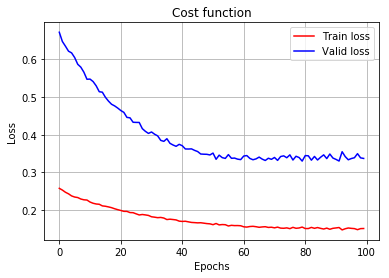

In [15]:
model.show_history()

# Testing

In [16]:
h = model.predict(Xtest, normalize=True)

In [17]:
ytest.shape, h.shape

((142, 1), (142, 1))

In [18]:
h = np.rint(np.array(list(map(lambda x: round(x, 3), h.ravel()))))

In [19]:
ytest = ytest.ravel() 

In [20]:
print('Accuracy: ', sum(ytest == h) / len(h) * 100)

Accuracy:  81.6901408451
